In [ ]:
from datetime import datetime, timedelta, timezone
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from alpaca.data.historical import CryptoHistoricalDataClient
from sklearn.model_selection import train_test_split

from sklearn.tree import export_graphviz

#Full document created by  - Adisesh Yeragudi




In [ ]:
"""
HELPER METHODS
"""

# Creating a request object to pass to alpaca client
def create_request_params():
    return CryptoBarsRequest(
      symbol_or_symbols=["BTC/USD"],
      timeframe=TimeFrame.Day,
      start=datetime(2021, 1, 1),
      end=datetime(2025, 4, 1)
    )

def na_fill(df):

    #filling na values for quantitative fields

    for col in df.columns:
        if df[col].dtype in ['float64', 'int64']:
            df[col].fillna(df[col].mean(), inplace=True)

#lag values - use previous day close values as a feature as well. allows to bridge the gap better for each row from previous day
    #so we can keep a "fluid" understanding of day to day
    df['close_lag_1'] = df['close'].shift(1)
    df['return_1h'] = df['close'].pct_change()
    df['vwap_lag_1'] = df['vwap'].shift(1)

    #additional features

    #range for allowing the decision trees to have an understanding of security volatility. Intraday security volatility allows us to
    #understand where close may fall in relation to the range normally
    df['range'] = df['high'] - df['low']

    #another range based / placement based indicator. Can allow us to understand BTC prices average in relation to open/clsoe pricing
    df['close_open_diff'] = df['close'] - df['open']

    #can allow model to use avg_trade size as a feature in terms of price relation to size
    df['avg_trade_size'] = df['volume'] / df['trade_count']

    #vwap tells us what price the market was willing to trade the most. close_vs_vwap allows decision trees to determine how important/how related
    #vwap and close price are. If information gain is high for vwap, it will allow this metric to add to that
    df['close_vs_vwap'] = df['close'] - df['vwap']

    #allows us to track steady trends over time
    df['rolling_mean_3'] = df['close'].rolling(3).mean()

    df = df.dropna()

    return df

def graphing_function(train_df, y_pred, y_real):
    timestamps_test = train_df.index.get_level_values('timestamp')

    plt.figure(figsize=(14, 6))

    plt.plot(timestamps_test, y_real, label='Actual Close Price', color='blue')

    plt.plot(timestamps_test, y_pred, label='Predicted Close Price', color='red', linestyle='--')

    plt.title('Actual vs Predicted Close Price Over Time')
    plt.xlabel('Time')
    plt.ylabel('Price (USD)')

    plt.legend()

    plt.grid(True)

    plt.tight_layout()

    plt.show()




In [ ]:
#get the data client from alpaca - no API keys required
client = CryptoHistoricalDataClient()

In [ ]:
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame

request_params = create_request_params()

In [ ]:
""" EXPLORATORY DATA ANALYSIS """

btc_bars = client.get_crypto_bars(request_params)

#collect the data into a pandas dataframe and show whats coming in
df = btc_bars.df
df.head(5)

#below, we fill any na values for quantitative fields from the data with normalized values - see na_fill function in helpers to
#guage what is occurring
df = na_fill(df)
df.head(5)

/var/folders/m9/sm93z1sx5r7ccxr42rzsgsyw0000gn/T/ipykernel_33730/2871939050.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)


open      high       low     close  \
symbol  timestamp                                                           
BTC/USD 2021-01-03 06:00:00+00:00  33769.52  34812.93  32300.61  32908.02   
        2021-01-04 06:00:00+00:00  32907.36  33496.03  27900.00  30441.57   
        2021-01-05 06:00:00+00:00  30461.84  35851.42  29927.55  35063.00   
        2021-01-06 06:00:00+00:00  35088.23  37810.00  33700.00  37485.27   
        2021-01-07 06:00:00+00:00  37486.29  40410.02  35936.73  38009.79   

                                        volume  trade_count          vwap  \
symbol  timestamp                                                           
BTC/USD 2021-01-03 06:00:00+00:00  1838.695433      58725.0  33505.269474   
        2021-01-04 06:00:00+00:00  2711.189503      69226.0  31267.965121   
        2021-01-05 06:00:00+00:00  1756.751333      61880.0  33151.367357   
        2021-01-06 06:00:00+00:00  1897.568734      65199.0  35720.825762   
        2021-01-07 06:00:00+00:00  2710.620043      71413.0  38472.947353   

                                   close_lag_1  return_1h    vwap_lag_1  \
symbol  timestamp                                                         
BTC/USD 2021-01-03 06:00:00+00:00     33769.52  -0.025511  31941.412694   
        2021-01-04 06:00:00+00:00     32908.02  -0.074950  33505.269474   
        2021-01-05 06:00:00+00:00     30441.57   0.151813  31267.965121   
        2021-01-06 06:00:00+00:00     35063.00   0.069083  33151.367357   
        2021-01-07 06:00:00+00:00     37485.27   0.013993  35720.825762   

                                     range  close_open_diff  avg_trade_size  \
symbol  timestamp                                                             
BTC/USD 2021-01-03 06:00:00+00:00  2512.32          -861.50        0.031310   
        2021-01-04 06:00:00+00:00  5596.03         -2465.79        0.039164   
        2021-01-05 06:00:00+00:00  5923.87          4601.16        0.028390   
        2021-01-06 06:00:00+00:00  4110.00          2397.04        0.029104   
        2021-01-07 06:00:00+00:00  4473.29           523.50        0.037957   

                                   close_vs_vwap  rolling_mean_3  
symbol  timestamp                                                 
BTC/USD 2021-01-03 06:00:00+00:00    -597.249474    32118.110000  
        2021-01-04 06:00:00+00:00    -826.395121    32373.036667  
        2021-01-05 06:00:00+00:00    1911.632643    32804.196667  
        2021-01-06 06:00:00+00:00    1764.444238    34329.946667  
        2021-01-07 06:00:00+00:00    -463.157353    36852.686667

In [ ]:
"""

The random forest approach will take features such
as open, high, low, close, volume, VWAP, etc., as input fea-
tures. We will initially begin with using 100 decision trees as
a baseline, and readjust accordingly based on cross-validation
results. We will also set a maximum initial depth of 10, with
5 samples per leaf. In order to predict future prices, we will
set the target variable as the close price at each hour interval
(the price at the end of the interval). This way we can keep
the time-series data within consideration. The random forest
will contain CART-like trees and train via bagging (bootstrap
aggregating). Our validation set will be 20% of our data while
we shall save 80% for training.


In our efforts, we will model both training fit, and test fit to see if the volatility of BTC prices
can be handled by random forests appropriately


"""

'\n\nThe random forest approach will take features such\nas open, high, low, close, volume, VWAP, etc., as input fea-\ntures. We will initially begin with using 100 decision trees as\na baseline, and readjust accordingly based on cross-validation\nresults. We will also set a maximum initial depth of 10, with\n5 samples per leaf. In order to predict future prices, we will\nset the target variable as the close price at each hour interval\n(the price at the end of the interval). This way we can keep\nthe time-series data within consideration. The random forest\nwill contain CART-like trees and train via bagging (bootstrap\naggregating). Our validation set will be 20% of our data while\nwe shall save 80% for training.\n\n\n\n'

In [ ]:
from sklearn.model_selection import train_test_split

df = df.sort_index(level='timestamp')

timestamps = df.index.get_level_values('timestamp')

train_df, test_df = train_test_split(df, test_size=0.2, shuffle=False, stratify=None)

X_train = train_df.drop(columns=['close'])
y_train = train_df['close']

X_test = test_df.drop(columns=['close'])
y_test = test_df['close']

print("Train Data Range: ", train_df.index.get_level_values('timestamp').min(), "to", train_df.index.get_level_values('timestamp').max())
print("Test Data Range: ", test_df.index.get_level_values('timestamp').min(), "to", test_df.index.get_level_values('timestamp').max())


Train Data Range:  2021-01-03 06:00:00+00:00 to 2024-05-25 05:00:00+00:00
Test Data Range:  2024-05-26 05:00:00+00:00 to 2025-03-31 05:00:00+00:00


In [ ]:
#trainging random forests

In [ ]:
from sklearn.ensemble import RandomForestRegressor

#implementing RF as discussed above - 100 Trees, min leaf node of 5, random state of 42 to enforce reproducability
rnd_reg = RandomForestRegressor(n_estimators=100,min_samples_leaf=5, random_state=42, n_jobs=-1)

In [ ]:
rnd_reg.fit(X_train, y_train)

RandomForestRegressor(min_samples_leaf=5, n_jobs=-1, random_state=42)

In [ ]:
""" TRAINING SET RESULTS """

"""

We model training results to verify if our algorithm was able to properly fit to our training input data

"""

'\n\nWe model training results to verify if our algorithm was able to properly fit to our training input data\n\n'

In [ ]:
"""

From our training results, we can see that our MAE and RMSE are within a tight range compared to our actual close prices.
This allows us to verify that the model is able to meet a minimum requirement in matching

"""

' \n\nFrom our training results, we can see that our MAE and RMSE are within a tight range compared to our actual close prices. \nThis allows us to verify that the model is able to meet a minimum requirement in matching\n\n'

In [ ]:
y_pred_train = rnd_reg.predict(X_train)

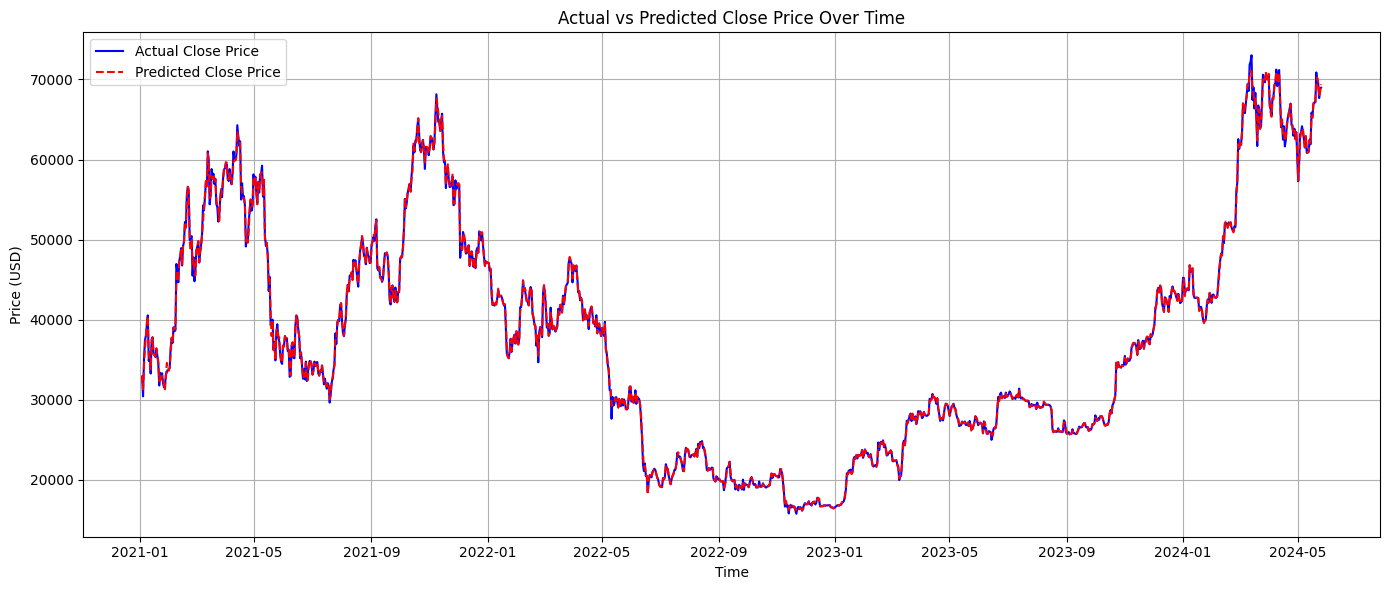

In [ ]:
graphing_function(train_df, y_pred_train, y_train)


In [ ]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

mae = mean_absolute_error(y_train, y_pred_train)
rmse = root_mean_squared_error(y_train, y_pred_train)

print(f"MAE: {mae}, RMSE: {rmse}")

MAE: 179.8003437862883, RMSE: 319.86935603159293


In [ ]:
""" TEST SET RESULTS """

' TEST SET RESULTS '

In [ ]:
"""

Upon predicting against our test set, we can see that the model is performing far worse compared to the training set. MAE and RMSE
are orders of magnitude larger than our training data and we will graph to help us visualize this challenge

"""

' \n\nUpon predicting against our test set, we can see that the model is performing far worse compared to the training set. MAE and RMSE\nare orders of magnitude larger than our training data and we will graph to help us visualize this challenge \n\n'

In [ ]:
y_pred = rnd_reg.predict(X_test)

In [ ]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print(f"MAE: {mae}, RMSE: {rmse}")



MAE: 11168.368843925178, RMSE: 16629.593509983544


In [ ]:
"""

Upon graphing our results, we can see that once BTC prices rapidly increase beyond a point in which our model has seen for close values,
it starts approximating the value in an almost constant like behavior. When prices are below 70,000 USD, we can see it performing
quite well. We will verify if our hyperparameters are the issue, or if it is a fundamental limitation with Radom Forests

"""

'\n\nUpon graphing our results, we can see that once BTC prices rapidly increase beyond a point in which our model has seen for close values,\nit starts approximating the value in an almost constant like behavior. When prices are below 70,000 USD, we can see it performing\nquite well. We will verify if our hyperparameters are the issue, or if it is a fundamental limitation with Radom Forests \n\n'

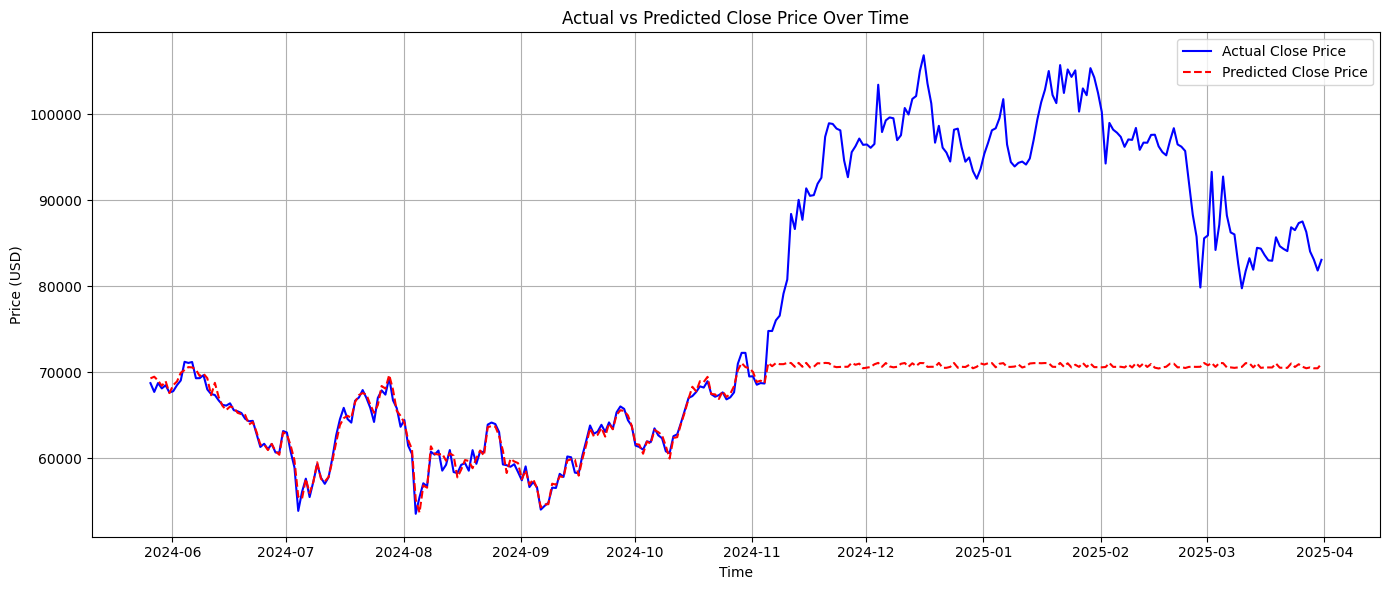

In [ ]:
graphing_function(test_df, y_pred, y_test)


In [ ]:
""" HYPERPARAMETER AND CROSS VALIDATION OPTIMIZATION """

' HYPERPARAMETER AND CROSS VALIDATION OPTIMIZATION '

In [ ]:
"""

Below we attempt to use a variety of hyperparameters (e.g. number of estimators included in our ensemble methodology,
depth of the trees themselves, etc.) in order to verify if our previous baseline model was the limiting factor or if it
spans across model hyperparameters.

As we can see based on our error metrics, we are able to improve the performance slightly, however our graph shows us that the
optimized model fails in a similar fashion to our baseline. As BTC prices spike beyond values in the training set, our random forest
approach is unable to predict effectively.

"""

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 500, 1000],
    'max_leaf_nodes': [10, 50, 100, 500],
    'max_depth': [None, 10, 20, 700],
    'min_samples_split': [2, 5, 10, 500]
}

grid_search = GridSearchCV(RandomForestRegressor(n_jobs=-1), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred_new = best_model.predict(X_test)


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/popen_loky_posix.py", line 180, in <module>
    exitcode = process_obj._bootstrap()
  File "/opt/anaconda3/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/anaconda3/lib/python3.12/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda

In [ ]:

mae = mean_absolute_error(y_test, y_pred_new)
rmse = root_mean_squared_error(y_test, y_pred_new)

print(f"MAE: {mae}, RMSE: {rmse}")

MAE: 10517.525970330069, RMSE: 15826.357651514993


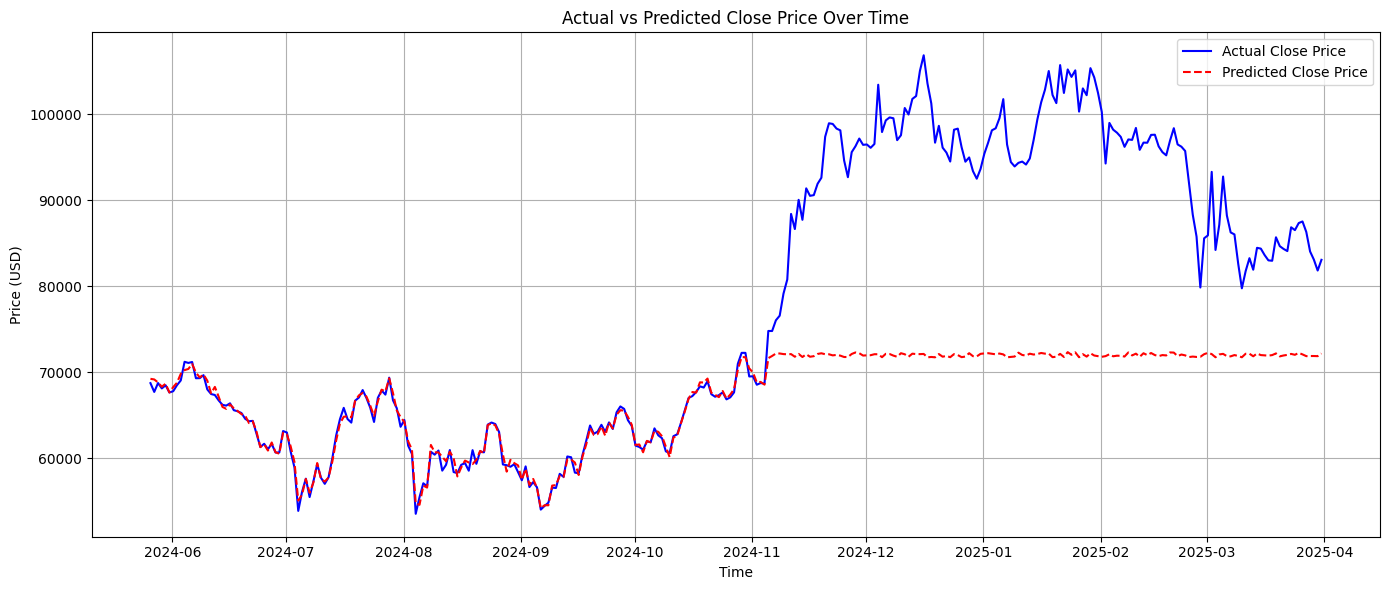

In [ ]:
graphing_function(test_df, y_pred_new, y_test)